In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import george
from george.kernels import ExpSquaredKernel

In [ ]:
#What's the point here?  
#See https://www.overleaf.com/5908814tkxdth#/19548885/ for problem statement
#Goals of this hack:
##make fake data in the form of true density field with probabilities of galaxy redshifts
##generate instantiations of observed density field based on those probabilities
##fit gaussian process to density field for each instantiation
##combine gaussian process samples to get estimator

In [2]:
#helper functions make observed catalog from true catalog given probabilities

def chooser_one(xt,xf,p):
    if np.random.uniform() < p:
        return xt
    return xf

def chooser_all(xts,xfs,ps):
    output = []
    for n in xrange(len(ps)):
        output.append(chooser_one(xts[n],xfs[n],ps[n]))
    return np.array(output)

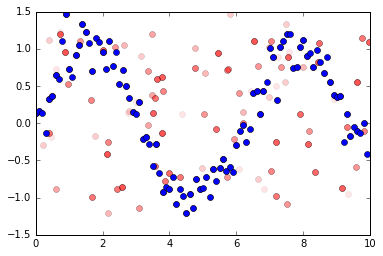

In [8]:
#try bigger samples!
ngals = 100
nsurvs = 10

#make the probabilities, could be smarter, need not be random for all lines
p = np.random.rand(ngals)

#choose density measurement locations
#there's actually no reason for these to be randomly sampled if they represent density values
#xt = 10 * np.sort(np.random.rand(ngals))
#now uniform distribution, like bins in density over redshift
xt = np.arange(0.,10.,0.1)

#fake redshifts
#try different prescriptions for this
#actually, this is fairly realistic because when it's a metal line, we don't know which one
#but it should have a bit of bias towards metal lines due to low-z galaxies and Ly-a due to high-z clouds
xf = 10 * np.random.rand(ngals)

#errors on densities
#there's no reason the errors have to be the same, should they be proportional/related to probabilities?
yerr = 0.2 * np.ones_like(xt)

#this is a totally stupid density model, permitting negative densities
#try different functions here, something realistic for density field
#the right thing would be the truth as a sample from the real 2PCF
y = np.sin(xt) + yerr * np.random.randn(len(xt))

#instantiations of the survey
xos = [chooser_all(xt,xf,p) for n in xrange(nsurvs)]

#plt.plot(xf,y)
for xo in xos:
    plt.plot(xo,y,'ro',alpha=1./nsurvs)
#plt.legend()
#print(p)
plt.plot(xt,y,'bo')
plt.savefig('inputs.png')

In [9]:
#stolen wholesale from DFM's documentation
#http://dan.iel.fm/george/current/user/quickstart/#a-simple-example

# Set up the Gaussian process.
kernel = ExpSquaredKernel(1.0)

In [10]:
gp_tru = george.GP(kernel)

# Pre-compute the factorization of the matrix.
gp_tru.compute(xt, yerr)

# Compute the log likelihood.
print(gp_tru.lnlikelihood(y))

gp_obss = [george.GP(kernel) for n in xrange(nsurvs)]

# Pre-compute the factorization of the matrix.
for n in xrange(nsurvs):
    gp_obss[n].compute(xos[n], yerr)
    # Compute the log likelihood.
    print(gp_obss[n].lnlikelihood(y))

-0.49485287612
-413.686071593
-379.649672476
-336.423194524
-386.054919168
-394.280991741
-350.028663592
-325.253932552
-350.737736243
-401.718760574
-441.965458474


In [11]:
t = np.linspace(0, 10, 500)

mu_tru, cov_tru = gp_tru.predict(y, t)
std_tru = np.sqrt(np.diag(cov_tru))

mu_obss,cov_obss = [],[]
for n in xrange(nsurvs):
    mu_obs, cov_obs = gp_obss[n].predict(y, t)
    mu_obss.append(mu_obs)
    cov_obss.append(cov_obs)
    #std_obs = np.sqrt(np.diag(cov_obs))

/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app
/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


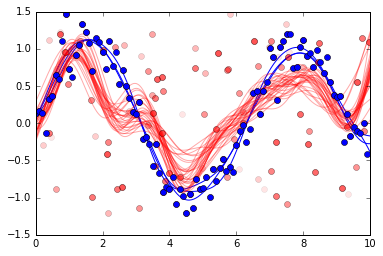

In [12]:
nsamps = 3
toplot_tru = np.random.multivariate_normal(mu_tru,cov_tru,nsamps)
toplot_obss = [np.random.multivariate_normal(mu_obss[n],cov_obss[n],nsamps) for n in xrange(nsurvs)]
for s in xrange(nsamps):
    plt.plot(t,toplot_tru[s],c='b')
for n in xrange(nsurvs):
    for s in xrange(nsamps):
        plt.plot(t,toplot_obss[n][s],c='r',alpha=1./nsamps)
    plt.plot(xos[n],y,'ro',alpha=1./nsurvs)
plt.plot(xt,y,'bo')
plt.savefig('outputs.png')

In [ ]:
#how to combine posterior samples from different survey instantiations?
#importance sampling, jackknifing, etc.